In [115]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../artifactory/')

In [116]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from artifact import Saw
from detector import WindowTransformerDetector

from data import ArtifactDataset, CachedArtifactDataset

In [117]:
torch.set_grad_enabled(False)

In [118]:
test_width = 1024
test_file = Path(f"../data/test_real{test_width}.pkl")
test_dataset = ["normalized_deviation_updated"]

In [119]:
def load_series(names: list[str], split: str):
    series = list()
    counts = list()
    for name in names:
        with open(f"../data/processed/{name}_{split}.pickle", "rb") as f:
            raw = [a for a in pickle.load(f) if len(a) > test_width]
            series.extend(np.array(a).astype(np.float32) for a in raw)
            counts.extend(repeat(1 / len(raw), len(raw)))
    counts = np.array(counts)
    return series, counts / counts.sum()

In [120]:
# validation
if not test_file.exists():
    val_data, val_weights = load_series(test_dataset, "TEST")
    val_gen = ArtifactDataset(val_data,
                              width=test_width,
                              padding=64,
                              artifact=Saw(),
                              weight=val_weights)
    val = CachedArtifactDataset.generate(val_gen,
                                         n=2048,
                                         to=test_file)
else:
    val = CachedArtifactDataset(file=test_file)



In [121]:
detector = WindowTransformerDetector.load_from_checkpoint("../models/model.ckpt").cpu()

In [143]:
example = val[9]
stride  = 64
window  = detector.window
length  = len(example["data"])

# artifacts already included in the data - no knowldge about
example_data = torch.tensor(example["data"])

# store prediction for each window
predictions = torch.zeros(((length - window) // stride + 1, length))

# store number of times each mask was predicted

mask = torch.zeros(length)
for i, j in enumerate(range(0, length - window + 1, stride)):
    # slice out window
    s = example_data[j : j + window]
    # make prediction and insert into prediction
    predictions[i, j : j + window] = detector(s.unsqueeze(0))
    # update count
    mask[j : j + window] += 1

In [144]:
predictions = predictions.sum(axis=0) / mask

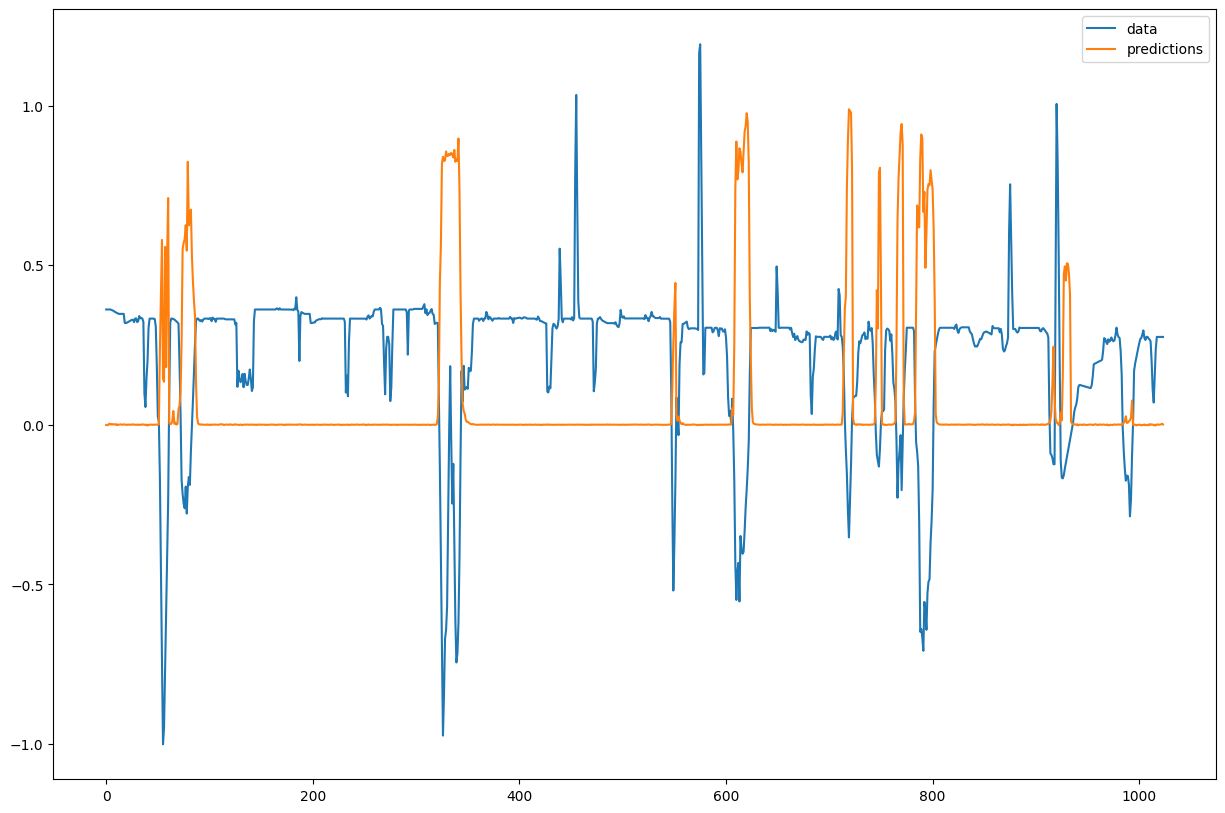

In [145]:
plt.figure(figsize=(15, 10))
plt.plot(example_data, label="data")
plt.plot(predictions, label="predictions")
plt.legend()
plt.show()